### Задание 2. Многоклассовая классификация

1. Подготовить анализ и обработку датасета
2. Необходимо получить модель классификации (из упоминаемых в лекции), дающую одинаково высокое качество на разных классах датасета
3. Качество модели продемонстрировать с помощью посчитанных метрик
4. Выложить на github

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=5ef099001e7ee95e47cf76a9b071276960008eb32586317ebaea7687d038b9a7
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import re
import spacy
import nltk
import pymorphy2
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

### Приводим датасет к рабочему виду

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/dataset.xlsx'
data = pd.read_excel(data)

data.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


In [ ]:
# удаление лишнего класса 'oid', это уникальный идентификатор для каждого текста, он нам не нужен
data = data.drop(columns=['oid'])
data.head()

,text,category
0,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,Не знаю как вам но мне стилистика нравится пус...,esport
4,Скриншоты из новой главы. Тэхунчика показали и...,esport


### Предобработка датасета

In [ ]:
nltk.download('punkt')

nlp = spacy.load("ru_core_news_sm")

russian_stopwords = nlp.Defaults.stop_words

morph = pymorphy2.MorphAnalyzer()

# удаление слов "tokenoid" и его производные
def remove_tokenoid(text):
    return re.sub(r'\b\w*token\w*oid\w*\b', '', text)

def clean_text(text):

    text = remove_tokenoid(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # смайлики
                               u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                               u"\U0001F680-\U0001F6FF"  # транспорт и символы
                               u"\U0001F1E0-\U0001F1FF"  # флаги
                               u"\U00002700-\U000027BF"  # различные символы
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'(?<!\w)[^А-Яа-яA-Za-z0-9\s](?!\w)', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # токенизация nltk
    words = word_tokenize(text)
    # стоп-слова spaCy
    words = [word for word in words if word not in russian_stopwords and len(word) > 1]
    # лемматизация pymorphy
    words = [morph.parse(word)[0].normal_form for word in words]

    return ' '.join(words)

data['clean_text'] = data['text'].apply(clean_text)

print(data[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                text  \
0  СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...   
1  Пусть это побудет здесь БорьбаВпрямомЭфире How...   
2  Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...   
3  Не знаю как вам но мне стилистика нравится пус...   
4  Скриншоты из новой главы. Тэхунчика показали и...   

                                          clean_text  
0  спочно сообщество продаваться покупка писать л...  
1                           побыть борьбавпрямомэфир  
2          раздача пиздюля мунсунг борьбавпрямомэфир  
3  знать стилистика нравиться пускай странный бор...  
4       скриншот новый глава тэхунчик показать хобин  


### Анализ датасета

Датасет состоит из столбца "text" (новости спорта/спортивный комментарий) и "category" (метка вида спорта, к которому относится новость). Более 50 тысяч данных.

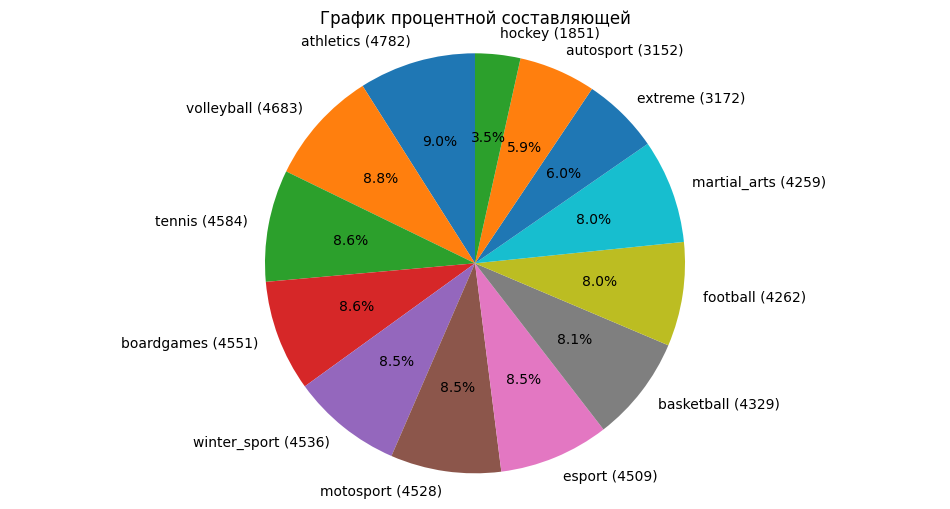

In [ ]:
# подсчёт количества категорий
class_counts = data['category'].value_counts()


plt.figure(figsize=(12, 6))
plt.pie(class_counts, labels=[f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)], autopct='%1.1f%%', startangle=90)
plt.title('График процентной составляющей')
plt.axis('equal')

plt.show()

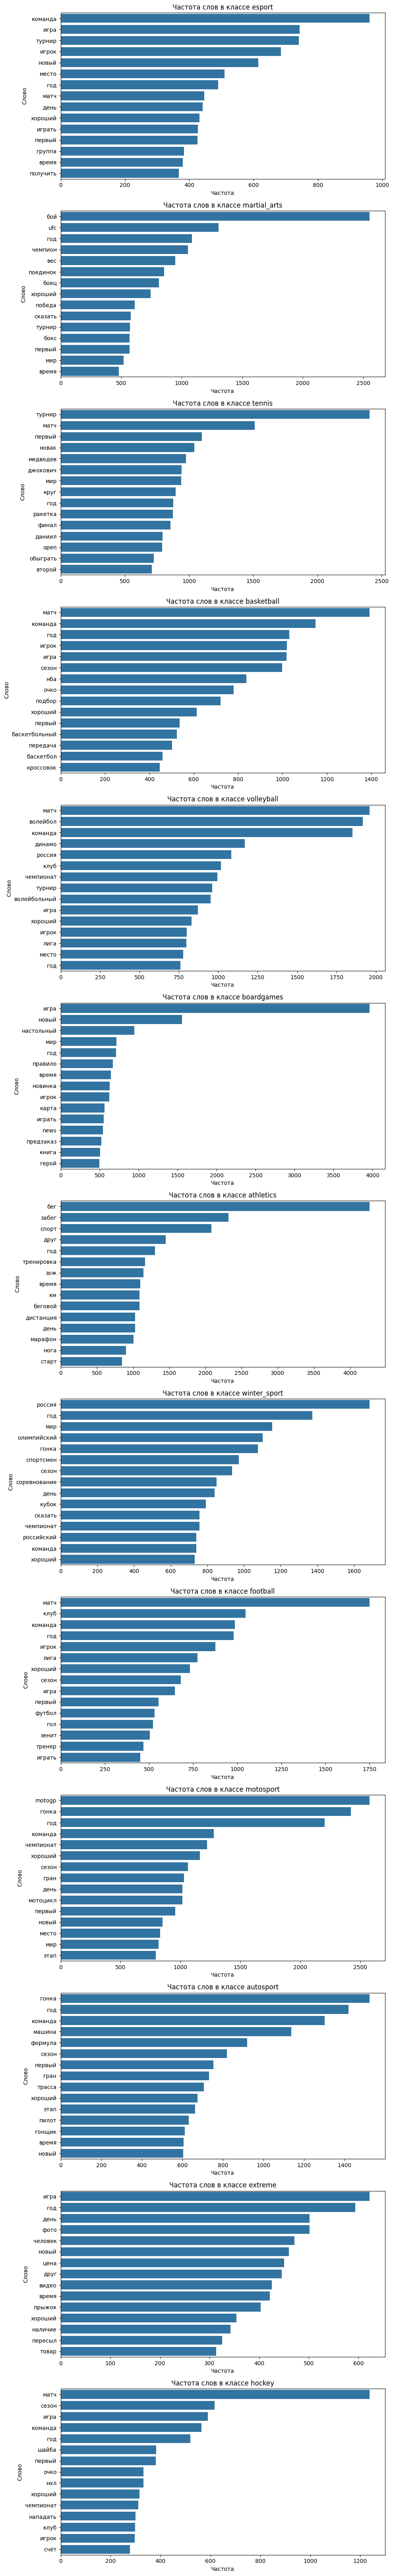

In [ ]:
# наиболее частые слова в каждой категории/классе
def plot_top_words_per_class(data, class_column, text_column, num_words=15):
    classes = data[class_column].unique()
    fig, axes = plt.subplots(len(classes), 1, figsize=(10, 5 * len(classes)))

    for i, cls in enumerate(classes):
        class_data = data[data[class_column] == cls]
        all_words = ' '.join(class_data[text_column]).split()
        word_freq = Counter(all_words).most_common(num_words)
        words, freqs = zip(*word_freq)

        if len(classes) > 1:
            ax = axes[i]
        else:
            ax = axes

        sns.barplot(x=list(freqs), y=list(words), ax=ax)
        ax.set_title(f'Частота слов в классе {cls}')
        ax.set_xlabel('Частота')
        ax.set_ylabel('Слово')

    plt.tight_layout()
    plt.show()

plot_top_words_per_class(data, class_column='category', text_column='clean_text', num_words=15)

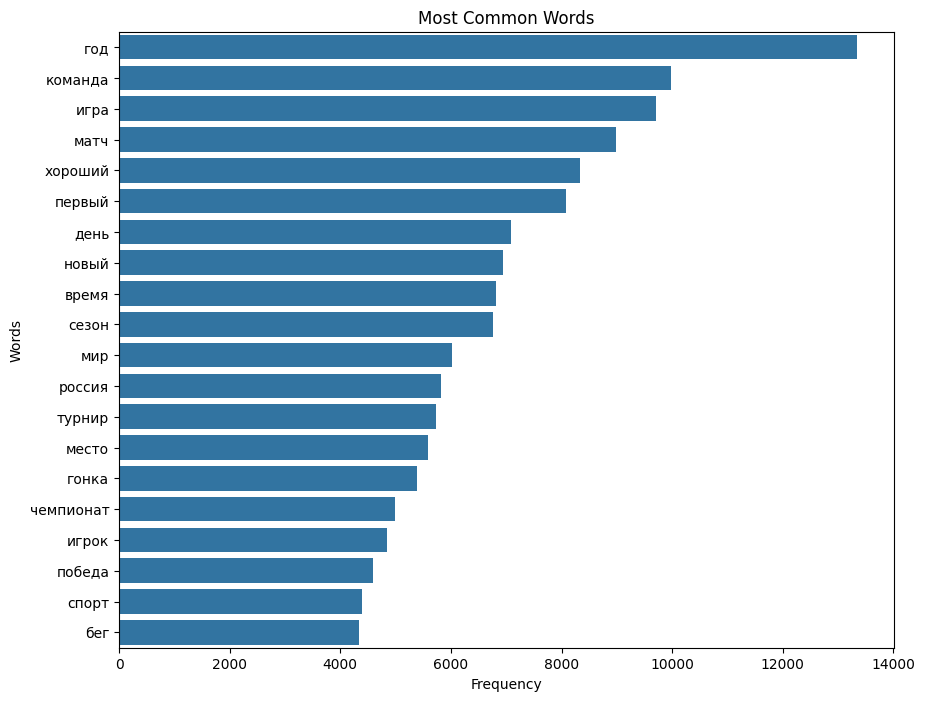

In [ ]:
# список самых частых слов
all_words = [word for tokens in data['tokens'] for word in tokens]
word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

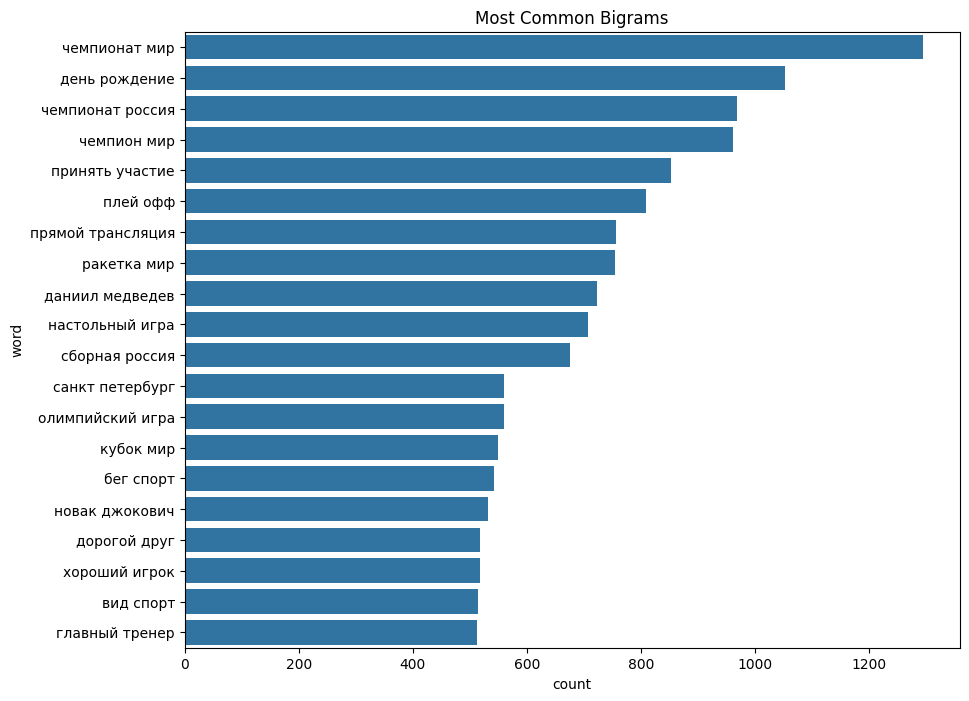

In [ ]:
# построение наиболее распространенных биграмм
def plot_ngrams(n, title):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(data['clean_text'])
    bag_of_words = vec.transform(data['clean_text'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:20]
    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

    plt.figure(figsize=(10, 8))
    sns.barplot(x='count', y='word', data=df_common_words)
    plt.title(title)
    plt.show()

plot_ngrams(2, 'Most Common Bigrams')

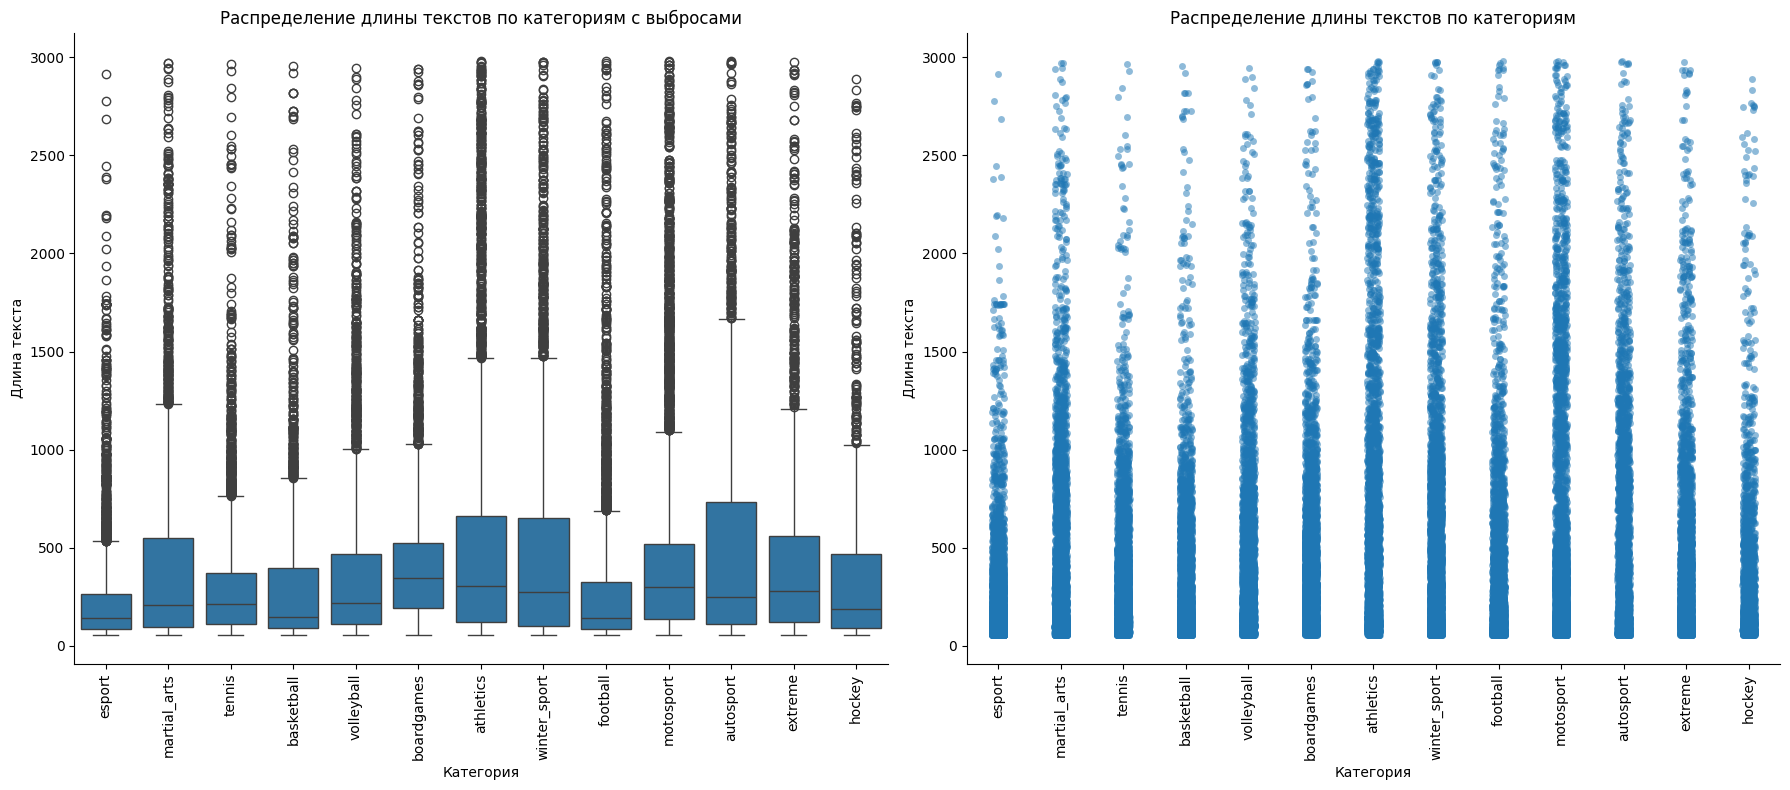

In [ ]:
data['text_length'] = data['text'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# выбросы
sns.boxplot(x='category', y='text_length', data=data, ax=axs[0])
axs[0].set_title('Распределение длины текстов по категориям с выбросами')
axs[0].set_xlabel('Категория')
axs[0].set_ylabel('Длина текста')
axs[0].tick_params(axis='x', rotation=90)

# визуализация отдельных точек данных
sns.stripplot(x='category', y='text_length', data=data, jitter=True, alpha=0.5, ax=axs[1])
axs[1].set_title('Распределение длины текстов по категориям')
axs[1].set_xlabel('Категория')
axs[1].set_ylabel('Длина текста')
axs[1].tick_params(axis='x', rotation=90)

for ax in axs:
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

### Разделение на тестовую и обучающую выборки

In [ ]:
X = data['clean_text']
y = data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Бейзлайн

Решила сделать бейзлайн, чтобы получить начальные метрики и понять, насколько сложная задача предстоит. Токенизация раннее выполнена с помощью nltk

In [ ]:
# преобразование меток в числовые значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# TF-IDF векторизация
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [ ]:
# обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train_encoded)

# предсказание на тестовых данных
y_pred = model.predict(X_test_tfidf)

# оценка модели
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   athletics       0.86      0.85      0.86       956
   autosport       0.87      0.77      0.82       611
  basketball       0.88      0.84      0.86       821
  boardgames       0.91      0.95      0.93       949
      esport       0.69      0.81      0.75       906
     extreme       0.61      0.68      0.64       677
    football       0.78      0.78      0.78       871
      hockey       0.90      0.66      0.76       345
martial_arts       0.77      0.79      0.78       843
   motosport       0.86      0.87      0.86       948
      tennis       0.96      0.92      0.94       864
  volleyball       0.87      0.81      0.84       927
winter_sport       0.85      0.87      0.86       922

    accuracy                           0.83     10640
   macro avg       0.83      0.81      0.82     10640
weighted avg       0.83      0.83      0.83     10640



Результаты неожиданно очень хорошие, но можно попробовать модель посложнее —
 LSTM. Затем сравнить результаты.

### Modeling


In [ ]:
# токенизатор и эмбеддинг BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().cpu().numpy()

Оценка получившегося эмбеддинга

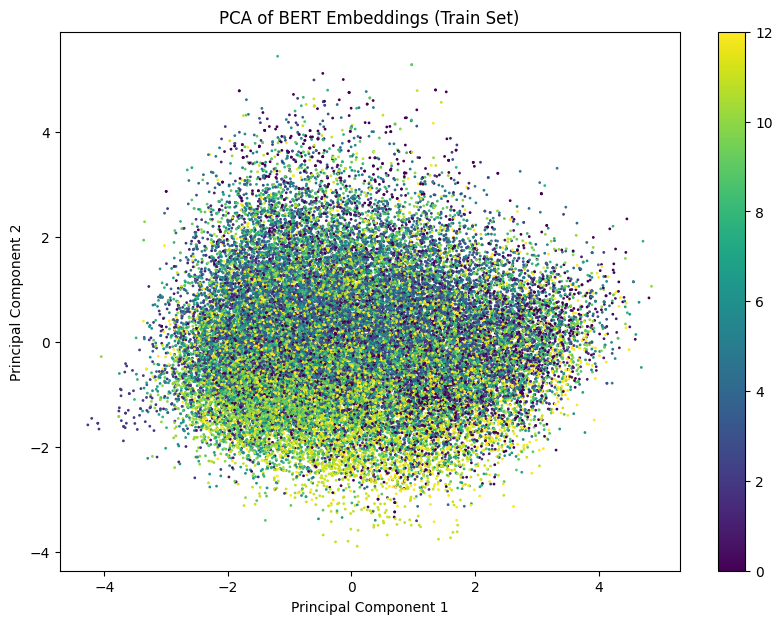

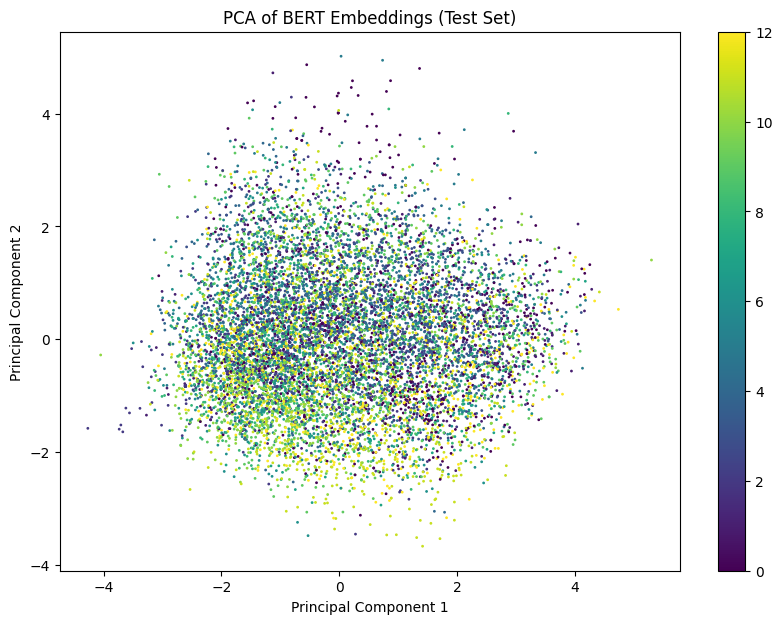

In [ ]:
X_train_embeddings_2d = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_test_embeddings_2d = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_embeddings_2d)
X_test_pca = pca.transform(X_test_embeddings_2d)

# визуализация для train
plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=np.argmax(y_train_encoded, axis=1), cmap='viridis', s=1)
plt.colorbar()
plt.title('PCA of BERT Embeddings (Train Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# визуализация для test
plt.figure(figsize=(10, 7))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=np.argmax(y_test_encoded, axis=1), cmap='viridis', s=1)
plt.colorbar()
plt.title('PCA of BERT Embeddings (Test Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
X_train_embeddings = np.array([get_bert_embeddings(text) for text in X_train])
X_test_embeddings = np.array([get_bert_embeddings(text) for text in X_test])

# преобразование меток в массив numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
np.save('X_train_embeddings_bert.npy', X_train_embeddings)
np.save('X_test_embeddings_bert.npy', X_test_embeddings)
np.save('y_train_bert.npy', y_train)
np.save('y_test_bert.npy', y_test)

In [ ]:
X_train_embeddings = X_train_embeddings.astype(np.float32)
X_test_embeddings = X_test_embeddings.astype(np.float32)

In [ ]:
print(f'X_train_embeddings shape: {X_train_embeddings.shape}')
print(f'X_test_embeddings shape: {X_test_embeddings.shape}')

X_train_embeddings shape: (42558, 768)
X_test_embeddings shape: (10640, 768)


Собираем LSTM

In [ ]:
# кодирование меток
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# измерение для временных шагов
X_train_embeddings = X_train_embeddings.reshape((X_train_embeddings.shape[0], 1, X_train_embeddings.shape[1]))
X_test_embeddings = X_test_embeddings.reshape((X_test_embeddings.shape[0], 1, X_test_embeddings.shape[1]))

# формы входных данных и выхода
input_shape = (X_train_embeddings.shape[1], X_train_embeddings.shape[2])
output_dim = y_train_encoded.shape[1]

# создание модели
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax'))

# компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# обучение
history = model.fit(X_train_embeddings, y_train_encoded, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# оценка на тестовых данных
loss, accuracy = model.evaluate(X_test_embeddings, y_test_encoded)
print(f'Test Accuracy: {accuracy}')

# предсказание и оценка результатов
y_pred = model.predict(X_test_embeddings)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

X_train_embeddings shape: (42558, 768)
X_test_embeddings shape: (10640, 768)
y_train_encoded shape: (42558, 13)
y_test_encoded shape: (10640, 13)


Epoch 1/50
266/266 [==============================] - 23s 24ms/step - loss: 2.5755 - accuracy: 0.2412 - val_loss: 1.9019 - val_accuracy: 0.4053
Epoch 2/50
266/266 [==============================] - 7s 25ms/step - loss: 1.7549 - accuracy: 0.4352 - val_loss: 1.3634 - val_accuracy: 0.5539
Epoch 3/50
266/266 [==============================] - 5s 20ms/step - loss: 1.5200 - accuracy: 0.5166 - val_loss: 1.2566 - val_accuracy: 0.5969
Epoch 4/50
266/266 [==============================] - 7s 26ms/step - loss: 1.4133 - accuracy: 0.5563 - val_loss: 1.2359 - val_accuracy: 0.6070
Epoch 5/50
266/266 [==============================] - 5s 20ms/step - loss: 1.3470 - accuracy: 0.5854 - val_loss: 1.2034 - val_accuracy: 0.6225
Epoch 6/50
266/266 [==============================] - 7s 25ms/step - loss: 1.2867 - accuracy: 0.6039 - val_loss: 1.1694 - val_accuracy: 0.6396
Epoch 7/50
266/266 [==============================] - 5s 20ms/step - loss: 1.2497 - accuracy: 0.6231 - val_loss: 1.1536 - val_accuracy: 0.650

Результат несколько хуже бейзлайна, но удовлетворителен. Возможно, проблемы с моделью, данными или их предобработкой.

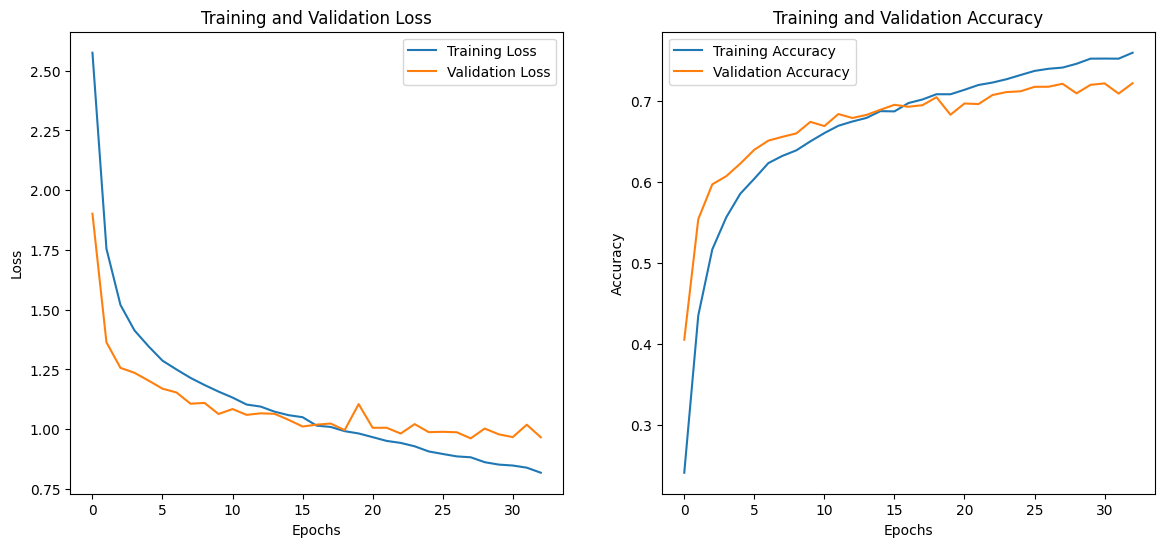

In [ ]:
# график функции потерь
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# график accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

333/333 [==============================] - 2s 7ms/step


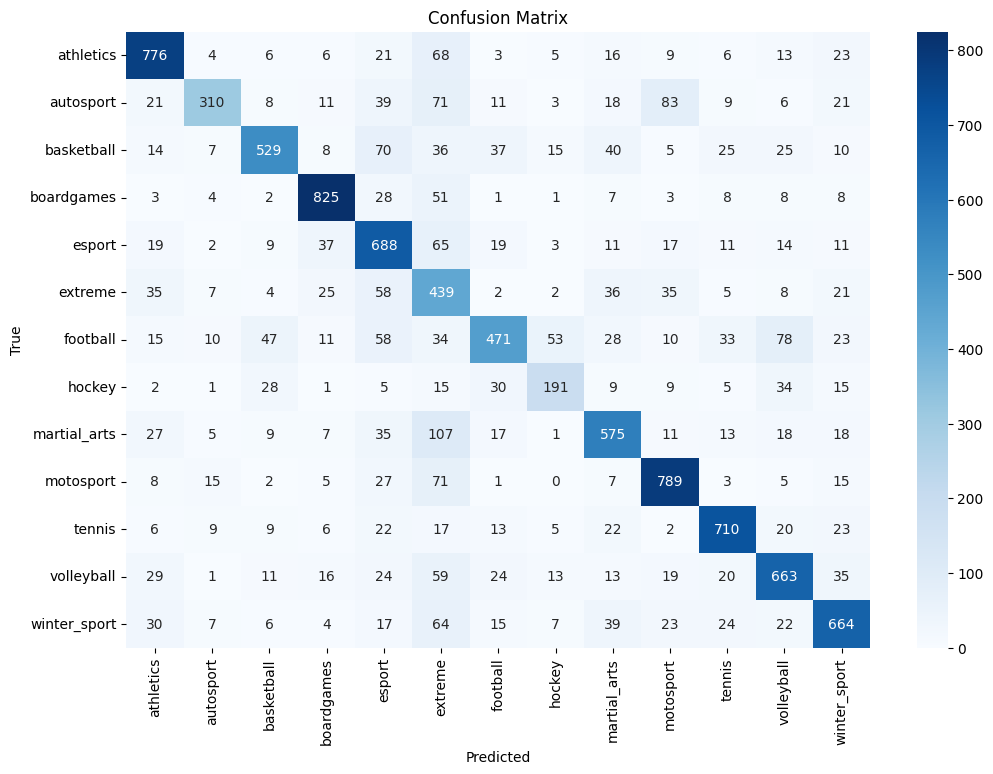

In [ ]:
y_pred = np.argmax(model.predict(X_test_embeddings), axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()